# Wines Points prediction 

Submission Date : 3.6.2023
Task: Predict the wine score given the inputs
Instructions:
 * Use logistic regression as benchmark model
 * Use sklearn pipeliens + cv + grid search with sklearn models (e.g. KNNs, RandomForest, etc.)
 * Compare all models on proper metric (your choice)

For DNN course project:
* Use sklearn pipeliens with tensorflow models (w/wo embeddings, LSTMs, RNNs, Transformers etc.)
* Compare all models on proper metric (your choice)

In [1]:
%pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install ttp

Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [4]:
import pandas as pd
import cufflinks as cf; cf.go_offline()
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import re
import numpy as np
import string
import emoji
import re as regex
import nltk
nltk.download('stopwords')
nltk.download('punkt')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shakeda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shakeda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [116]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
wine_reviews = pd.read_csv("winemag-data-130k-v2.csv")
wine_reviews.rename({'Unnamed: 0':'id'}, axis=1,inplace=True)
# wine_reviews.drop(['Unnamed: 0'], axis=1, inplace=True)
wine_reviews.shape

(129971, 14)

In [6]:
wine_reviews.id=wine_reviews.id+1
wine_reviews.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,1,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,2,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,3,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,4,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,5,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


EDA REQUIREMNET: 
    1. Type of colunms
    2. unique values 
    3. Positive rate
    4. null/empty vaules
    5. duplicated records
    6. correlation features to target col
    7. low varianve columns - removal
    8. Confirm No Dupes with Different rate

### EDA - Data Description

In [7]:
wine_reviews.describe()

,id,points,price
count,129971.000000,129971.000000,120975.000000
mean,64986.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,1.000000,80.000000,4.000000
25%,32493.500000,86.000000,17.000000
50%,64986.000000,88.000000,25.000000
75%,97478.500000,91.000000,42.000000
max,129971.000000,100.000000,3300.000000


In [8]:
wine_reviews.describe(include="all")

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,129971.000000,129908,129971,92506,129971.000000,120975.000000,129908,108724,50511,103727,98758,129971,129970,129971
unique,NaN,43,119955,37979,NaN,NaN,425,1229,17,19,15,118840,707,16757
top,NaN,US,"Seductively tart in lemon pith, cranberry and ...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,NaN,54504,3,2009,NaN,NaN,36247,4480,11065,25514,25514,11,13272,222
mean,64986.000000,NaN,NaN,NaN,88.447138,35.363389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,37519.540256,NaN,NaN,NaN,3.039730,41.022218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,32493.500000,NaN,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,64986.000000,NaN,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,97478.500000,NaN,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
wine_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


### EDA - Null Value Check on Target Field

In [11]:
len(wine_reviews[wine_reviews.points.isnull()])

0

### EDA - Duplication Check

In [12]:
wine_reviews[wine_reviews.duplicated()]

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery


In [13]:
len(wine_reviews[wine_reviews.duplicated()])

0

### EDA - Drop Duplications 

In [14]:
wine_reviews.drop_duplicates(inplace=True)
len(wine_reviews)

129971

### EDA - Investigate Target Field

In [15]:
wine_reviews.points.unique()

array([ 87,  86,  85,  88,  92,  91,  90,  89,  83,  82,  81,  80, 100,
        98,  97,  96,  95,  93,  94,  84,  99])

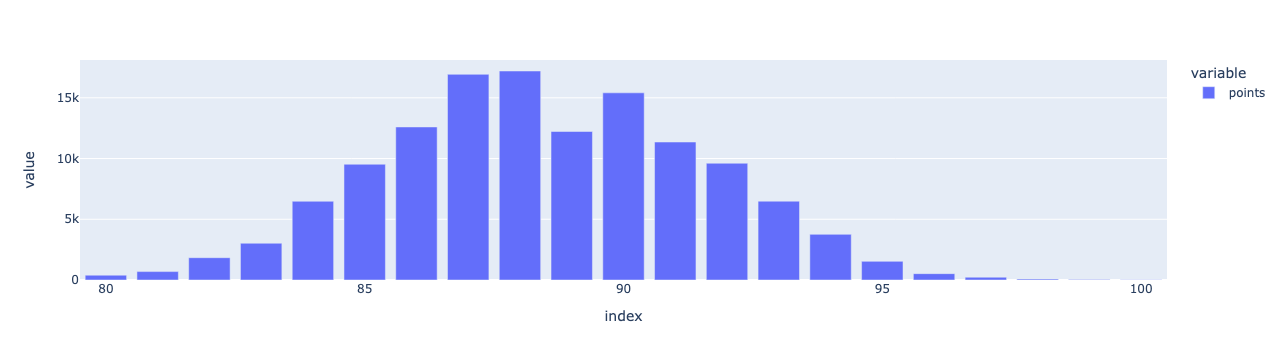

In [16]:
px.bar(wine_reviews.points.value_counts())

In [17]:
# px.bar(pd.DataFrame(wine_reviews.points.value_counts()).T, barmode="group",labels=True)

### EDA - 

In [18]:
wine_reviews['vintage'] = wine_reviews['title'].str.extract(r'.*([1-3][0-9]{3})')

In [19]:
for col in wine_reviews.columns:
    if col in {"description", 'designation','title','price','winery','region_1','region_2', 'province','id',} :
        continue
    print(col, ':', len(wine_reviews[col].value_counts()))
    # px.bar(wine_reviews[col].value_counts().sort_values()).show()

country : 43
points : 21
taster_name : 19
taster_twitter_handle : 15
variety : 707
vintage : 158


clean categorical fields (wo description)

In [20]:
for col in wine_reviews.columns:
    if type(wine_reviews[col][0])==str and col!='description':
        number_val_b4clean = wine_reviews[col].nunique()
        print(col, "number of unique value:",wine_reviews[col].nunique())
        wine_reviews[col] = wine_reviews[col].str.lower()
        number_val_afterclean = wine_reviews[col].nunique()
        if number_val_b4clean != number_val_afterclean :
            print(col, "number of unique value after cleaning:",wine_reviews[col].nunique())

country number of unique value: 43
designation number of unique value: 37979
designation number of unique value after cleaning: 37721
province number of unique value: 425
region_1 number of unique value: 1229
taster_name number of unique value: 19
taster_twitter_handle number of unique value: 15
title number of unique value: 118840
title number of unique value after cleaning: 118832
variety number of unique value: 707
winery number of unique value: 16757
winery number of unique value after cleaning: 16731
vintage number of unique value: 158


In [21]:
wine_reviews.winery.sort_values().nunique()

16731

In [22]:
wine_reviews.winery.str.lower().sort_values().nunique()

16731

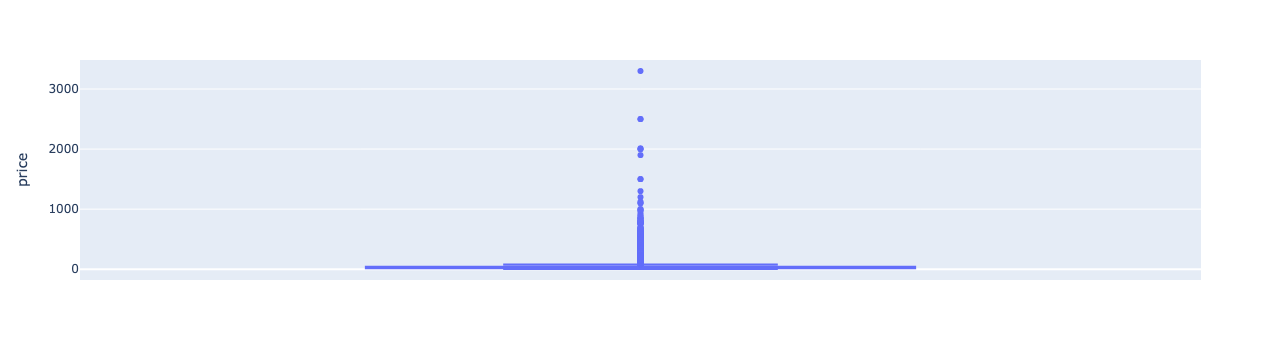

In [23]:
fig = px.box(wine_reviews, y="price")
fig

### Drop Outliers

### check vintage - drop all records that appear only one 

In [25]:
wine_reviews.vintage.nunique()

158

In [26]:
vintage_count = wine_reviews.groupby(['vintage'])['vintage','id'].count().sort_values(by=['id'], ascending=False)
vintage_count = vintage_count[vintage_count['id'] > 1]
vintage_list = list(vintage_count.index)

/var/folders/_h/s37wprh55kx4m2kwbbj_lh79_34czk/T/ipykernel_59434/4246430209.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [27]:
vintage_list.sort()
vintage_list[60:-5]

['1964',
 '1966',
 '1973',
 '1978',
 '1979',
 '1980',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017']

In [28]:
wine_reviews = wine_reviews[wine_reviews['vintage'].isin(list(vintage_list[60:-4]))]
wine_reviews.vintage.nunique()

42

### check variety - drop all records that appear only one 

In [29]:
wine_reviews.variety.nunique()

695

In [30]:
variety_count = wine_reviews.groupby(['variety'])['variety','id'].count().sort_values(by=['id'], ascending=False)
variety_count = variety_count[variety_count['id'] > 4]

/var/folders/_h/s37wprh55kx4m2kwbbj_lh79_34czk/T/ipykernel_59434/1187081510.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [31]:
wine_reviews = wine_reviews[wine_reviews['variety'].isin(list(variety_count.index))]

In [32]:
wine_reviews.shape

(124442, 15)

In [33]:
wine_reviews.variety.nunique()

385

### check winery - drop all records that appear only one

In [39]:
wine_reviews.winery.nunique()

16249

In [40]:
gb_winery = wine_reviews.groupby(['points','winery'])['winery','id'].count().sort_values(by=['points','id'], ascending=False)
gb_winery = gb_winery[gb_winery['id'] > 2]

gb_winery.index.get_level_values(1)

/var/folders/_h/s37wprh55kx4m2kwbbj_lh79_34czk/T/ipykernel_59434/1278896535.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Index(['williams selyem', 'alpha omega', 'louis jadot', 'williams selyem',
       'louis jadot', 'cayuse', 'domaine leflaive', 'kracher',
       'château haut-brion', 'château la mission haut-brion',
       ...
       'stephen vincent', 'vega sindoa', 'veramar',
       'woodbridge by robert mondavi', 'x', 'bodegas del mundo', 'love',
       'peirano', 'pietra santa', 'santa alicia'],
      dtype='object', name='winery', length=13884)

In [41]:
wine_reviews = wine_reviews[wine_reviews['winery'].isin(list(gb_winery.index.get_level_values(1)))]
wine_reviews.shape

(95286, 15)

In [42]:
wine_reviews.winery.nunique()

5169

In [46]:
for field in ['variety', 'winery']:
    group_by_df = wine_reviews.groupby([field])['points'].mean().sort_values(ascending=False).reset_index()
    new_name_avg = 'avg points ' + field
    group_by_df.rename({'points': new_name_avg}, axis=1, inplace=True)
    min_avg = group_by_df[new_name_avg].min()
    max_avg = group_by_df[new_name_avg].max()
    # group_by_df['normalized '+ new_name_avg] = (group_by_df[new_name_avg]-min_avg)/(max_avg-min_avg)
    wine_reviews = wine_reviews.merge(group_by_df, on=field, how='right')
wine_reviews.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,avg points variety,normalized avg points variety,avg points winery,normalized avg points winery
0,1565,italy,The 2008 Ornellaia delivers concentrated aroma...,ornellaia,97,215.0,tuscany,bolgheri superiore,NaN,NaN,NaN,tenuta dell'ornellaia 2008 ornellaia (bolgher...,red blend,tenuta dell'ornellaia,2008,88.692534,0.604164,96.7,1.0
1,31207,italy,Le Serre Nuove presents an intense and harmoni...,le serre nuove,93,60.0,tuscany,bolgheri,NaN,NaN,NaN,tenuta dell'ornellaia 2007 le serre nuove (bo...,red blend,tenuta dell'ornellaia,2007,88.692534,0.604164,96.7,1.0
2,45802,italy,"Consistently among Italy's top-scoring wines, ...",ornellaia,97,200.0,tuscany,bolgheri superiore,NaN,NaN,NaN,tenuta dell'ornellaia 2006 ornellaia (bolgher...,red blend,tenuta dell'ornellaia,2006,88.692534,0.604164,96.7,1.0
3,79106,italy,This is a hopelessly gorgeous wine with so muc...,ornellaia,98,175.0,tuscany,bolgheri superiore,NaN,NaN,NaN,tenuta dell'ornellaia 2004 ornellaia (bolgher...,red blend,tenuta dell'ornellaia,2004,88.692534,0.604164,96.7,1.0
4,81394,italy,"Spicy and full of cassis, tobacco and coffee a...",ornellaia,96,125.0,tuscany,bolgheri,NaN,michael schachner,@wineschach,tenuta dell'ornellaia 1999 ornellaia (bolgheri),red blend,tenuta dell'ornellaia,1999,88.692534,0.604164,96.7,1.0


## NLP

In [48]:
specialChars = ''.join([",", ":", "\"", "=", "&", ";", "%", "$","@", "%", "^", "*", "(", ")", "{", "}",'–','“', '”'
                      "[", "]", "|", "/", "\\", ">", "<", "-","!", "?", ".", "'","--", "---", "#", '‘', '’', '…','—'])  
space_chars = ['.',',',';', '&', '?','!']
def remove_by_regex(description, regexp):
    return description.replace(regexp, "")

def remove_urls(description):
    return remove_by_regex(description, regex.compile(r"http\S+"))

def remove_special_chars(description): 
    return description.apply(lambda description: ''.join([c for c in description if c not in specialChars]))

def remove_usernames(description):
    return remove_by_regex(description, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(description):
    return remove_by_regex(description, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

def remove_emojis(description):
    return description.apply(lambda description: ''.join(c for c in description if c not in emoji.distinct_emoji_list(description)))

def add_spaces(description):
    def add_spaces_int(description):
        for char in space_chars:
            description = description.replace(char, char + ' ')
        return description
    return description.apply(lambda description: add_spaces_int(description))

def leave_language_only(description):
    for f in [remove_urls, remove_emojis, add_spaces, remove_numbers, remove_usernames, remove_special_chars]:
        description = f(description)
    return description

wine_reviews['pureTextdescription'] = leave_language_only(wine_reviews.description.str.lower())
wine_reviews[['description','pureTextdescription']].sample(5)
# wine_reviews.to_csv("winemag-data-130k-v2_nlp.csv")
wine_reviews.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,avg points variety,normalized avg points variety,avg points winery,normalized avg points winery,pureTextdescription
0,1565,italy,The 2008 Ornellaia delivers concentrated aroma...,ornellaia,97,215.0,tuscany,bolgheri superiore,NaN,NaN,NaN,tenuta dell'ornellaia 2008 ornellaia (bolgher...,red blend,tenuta dell'ornellaia,2008,88.692534,0.604164,96.7,1.0,the ornellaia delivers concentrated aromas of ...
1,31207,italy,Le Serre Nuove presents an intense and harmoni...,le serre nuove,93,60.0,tuscany,bolgheri,NaN,NaN,NaN,tenuta dell'ornellaia 2007 le serre nuove (bo...,red blend,tenuta dell'ornellaia,2007,88.692534,0.604164,96.7,1.0,le serre nuove presents an intense and harmoni...
2,45802,italy,"Consistently among Italy's top-scoring wines, ...",ornellaia,97,200.0,tuscany,bolgheri superiore,NaN,NaN,NaN,tenuta dell'ornellaia 2006 ornellaia (bolgher...,red blend,tenuta dell'ornellaia,2006,88.692534,0.604164,96.7,1.0,consistently among italys topscoring wines th...
3,79106,italy,This is a hopelessly gorgeous wine with so muc...,ornellaia,98,175.0,tuscany,bolgheri superiore,NaN,NaN,NaN,tenuta dell'ornellaia 2004 ornellaia (bolgher...,red blend,tenuta dell'ornellaia,2004,88.692534,0.604164,96.7,1.0,this is a hopelessly gorgeous wine with so muc...
4,81394,italy,"Spicy and full of cassis, tobacco and coffee a...",ornellaia,96,125.0,tuscany,bolgheri,NaN,michael schachner,@wineschach,tenuta dell'ornellaia 1999 ornellaia (bolgheri),red blend,tenuta dell'ornellaia,1999,88.692534,0.604164,96.7,1.0,spicy and full of cassis tobacco and coffee a...


In [49]:
stopwords=nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

## Bag of words - One hot Encoding

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
wine_reviews.shape

(95286, 20)

In [251]:
wine_reviews_lean = wine_reviews[['country', 'price', 'taster_name',
                                 'vintage', 'avg points variety', 'avg points winery',
                                'points','pureTextdescription','variety']]
target = 'points'
test_df, train_df = train_test_split(wine_reviews_lean, test_size=0.8, random_state=42)
train_df.dropna(axis=0, inplace=True)
test_df.dropna(axis=0, inplace=True)

train_df.shape, test_df.shape

((57277, 9), (14371, 9))

In [252]:
X_train, y_train = train_df.drop(target, axis=1), train_df[[target]]
X_test, y_test = test_df.drop(target, axis=1), test_df[[target]]

X_train.head()

,country,price,taster_name,vintage,avg points variety,avg points winery,pureTextdescription,variety
1430,us,50.0,virginie boone,2015,89.447748,92.937500,made from vines planted several decades ago t...,syrah
87386,chile,12.0,michael schachner,2013,86.683112,86.000000,tarry blackfruit aromas show a touch of oaky ...,carmenère
24179,us,39.0,virginie boone,2009,88.692534,90.137931,cedarvilles ode to priorat this is a mix of g...,red blend
32507,us,40.0,jim gordon,2014,88.779044,89.564516,touches of earth new leather and sweet vermou...,cabernet sauvignon
59928,us,18.0,paul gregutt,2005,88.665391,87.916667,fresh and leesy this stainless steelfermented...,pinot gris


In [55]:
train_words = [word for description in train_df.pureTextdescription for word in nltk.word_tokenize(description) if word.lower() not in stopwords] # Words without stop words

In [463]:
# ### final words set
words = pd.DataFrame(data = train_words, columns = ['word']).word.value_counts().reset_index()
words.columns = ['word','wordCount']
words = words[(words['wordCount']>20)&(words['wordCount']<len(X_train)/2)]
words

,word,wordCount
1,flavors,27587
2,fruit,20649
3,palate,20646
4,aromas,19485
5,finish,17480
...,...,...
4156,brix,21
4157,capped,21
4158,fumé,21
4159,bob,21


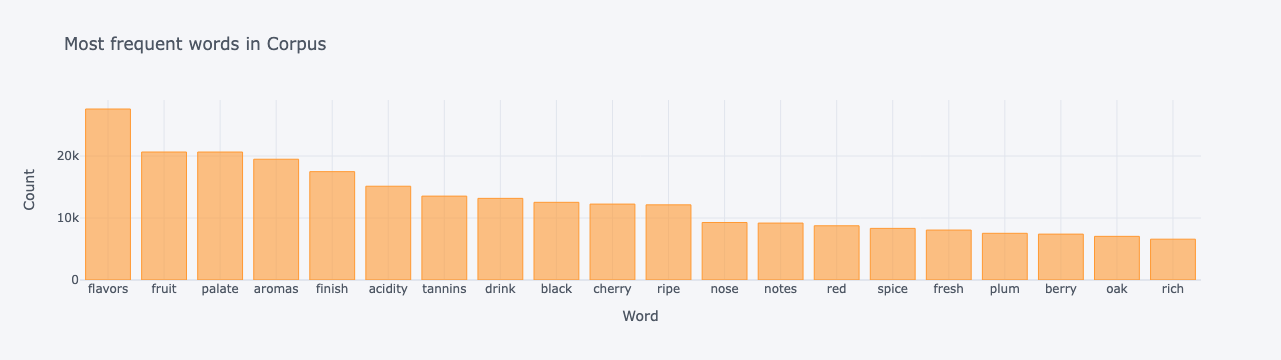

In [464]:
words.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [465]:
clean_vocab = set(words.word)
len(clean_vocab)

4160

In [466]:
clean_vocab_loop = clean_vocab.copy()
for word in clean_vocab_loop:
    if len(word)<3:
        # print(word)
        clean_vocab.remove(word)

In [467]:
len(clean_vocab)

4146

In [468]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


# Define categorical and numerical features
categorical_features = ['country', 'taster_name','variety']
numerical_features = ['price', 'vintage', 'avg points variety', 'avg points winery',]
des_feature = 'pureTextdescription'

# Create categorical and numerical transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

description_tansformer = Pipeline(steps=[
    ('idf', TfidfVectorizer(vocabulary = clean_vocab)),
    
])

# Combine transformers using ColumnTransformer
wine_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
       ('text',description_tansformer , des_feature),
    
        ], remainder='drop')

In [469]:
# Create a full pipeline with a classifier
full_pipeline = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('regressor', LinearRegression())
])

In [470]:
# x_tr = X_train['pureTextdescription']
X_train.shape, y_train.shape

((57277, 8), (57277, 1))

In [471]:
# Fit the pipeline to the training data
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price', 'vintage',
                                                   'avg points variety',
                                                   'avg points winery']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['co...
                                                                                               'abrasive',
                                                                                               'abrupt',
                                                                                               'abruptly',
                                                                                               'absolute',
                                                                                               'absolutely',
                                                                                               'abundance',
                                                                                               'abundant',
                                                                                               'abv',
                                                                                               'acacia',
                                                                                               'accent',
                                                                                               'accented',
                                                                                               'accenting',
                                                                                               'accents',
                                                                                               'accentuate',
                                                                                               'accentuated',
                                                                                               'accentuates',
                                                                                               'acceptable',
                                                                                               'accessible',
                                                                                               'accompanied',
                                                                                               'accompanies',
                                                                                               'accompaniment',
                                                                                               'accompany',
                                                                                               'accompanying',
                                                                                               'achieve',
                                                                                               'acid', ...}))]),
                                                  'pureTextdescription')])),


In [472]:
R_2 = full_pipeline.score(X_test, y_test)
print(f"Test R^2: {R_2:.3f}")

Test R^2: 0.761


In [489]:
np.mean(abs(full_pipeline.predict(X_test)-y_test))

points    1.114799
dtype: float64

[CV] END regressor=LinearRegression(), regressor__fit_intercept=True; total time=   4.9s
[CV] END regressor=DecisionTreeRegressor(), regressor__max_depth=8, regressor__min_samples_leaf=30; total time=   3.4s
[CV] END regressor=DecisionTreeRegressor(), regressor__max_depth=9, regressor__min_samples_leaf=29; total time=   4.0s
[CV] END regressor=DecisionTreeRegressor(), regressor__max_depth=9, regressor__min_samples_leaf=32; total time=   3.8s
[CV] END regressor=DecisionTreeRegressor(), regressor__max_depth=10, regressor__min_samples_leaf=30; total time=   4.2s
[CV] END regressor=DecisionTreeRegressor(), regressor__max_depth=11, regressor__min_samples_leaf=29; total time=   4.7s
[CV] END regressor=DecisionTreeRegressor(), regressor__max_depth=11, regressor__min_samples_leaf=32; total time=   4.5s
[CV] END regressor=DecisionTreeRegressor(), regressor__max_depth=12, regressor__min_samples_leaf=30; total time=   5.0s
[CV] END regressor=DecisionTreeRegressor(), regressor__max_depth=13, regre

### Grid Search

In [473]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge,Lasso

In [522]:
wine_param_grid = [
    {
        
        # 'preprocessor__des__max_features': [1000, 2000],
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]
        # 'classifier__n_neighbors': [5,20,100],
        # 'classifier__weights': ['uniform', 'distance']
    },
    {
        # 'preprocessor__des__max_features': [1000, 2000],
        'regressor': [DecisionTreeRegressor()],
        # 'classifier__n_estimators': [160, 240, 300],
        'regressor__max_depth': [8,9,10,11,12,13],
        'regressor__min_samples_leaf':[29,30,32],        
    },
    
    {
        'regressor':[Lasso()],
        'regressor__alpha':[0.1, 1.0, 10, 100]
    },
    
     {
         'regressor':[Ridge()],
         'regressor__alpha':np.arange(0.5, 0.7, 0.05)
     },
    {
        'regressor':[RandomForestRegressor()],
        'regressor__max_depth': [10,11],
        'regressor__min_samples_leaf':[10,30]
    },
]

In [523]:
grid_search.best_score_

0.7632982034779701

In [524]:
grid_search = GridSearchCV(full_pipeline, wine_param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Int

/Users/shakeda/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/shakeda/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/shakeda/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/shakeda/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A colum

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price',
                                                                          'vintage',
                                                                          'avg '
                                                                          'points '
                                                                          'variety',
                                                                          'avg '
                                                                          'points '
                                                                          'winery']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEnco...
                          'regressor__max_depth': [8, 9, 10, 11, 12, 13],
                          'regressor__min_samples_leaf': [29, 30, 32]},
                         {'regressor': [Lasso()],
                          'regressor__alpha': [0.1, 1.0, 10, 100]},
                         {'regressor': [Ridge(alpha=0.6000000000000001)],
                          'regressor__alpha': array([0.5 , 0.55, 0.6 , 0.65])},
                         {'regressor': [RandomForestRegressor()],
                          'regressor__max_depth': [10, 11],
                          'regressor__min_samples_leaf': [10, 30]}],
             scoring='r2', verbose=2)

In [525]:
grid_search.best_params_

{'regressor': Ridge(alpha=0.6000000000000001),
 'regressor__alpha': 0.6000000000000001}

In [526]:
R_2 = grid_search.score(X_test, y_test)
print(f"Test R^2: {R_2:.3f}")

Test R^2: 0.764


In [527]:
np.mean(abs(grid_search.predict(X_test)-y_test))

points    1.108499
dtype: float64

In [528]:
regressors = [str(reg.values()).split('dict_values(')[1] for reg in grid_search.cv_results_['params']]

In [529]:
r2s = grid_search.cv_results_['mean_test_score']

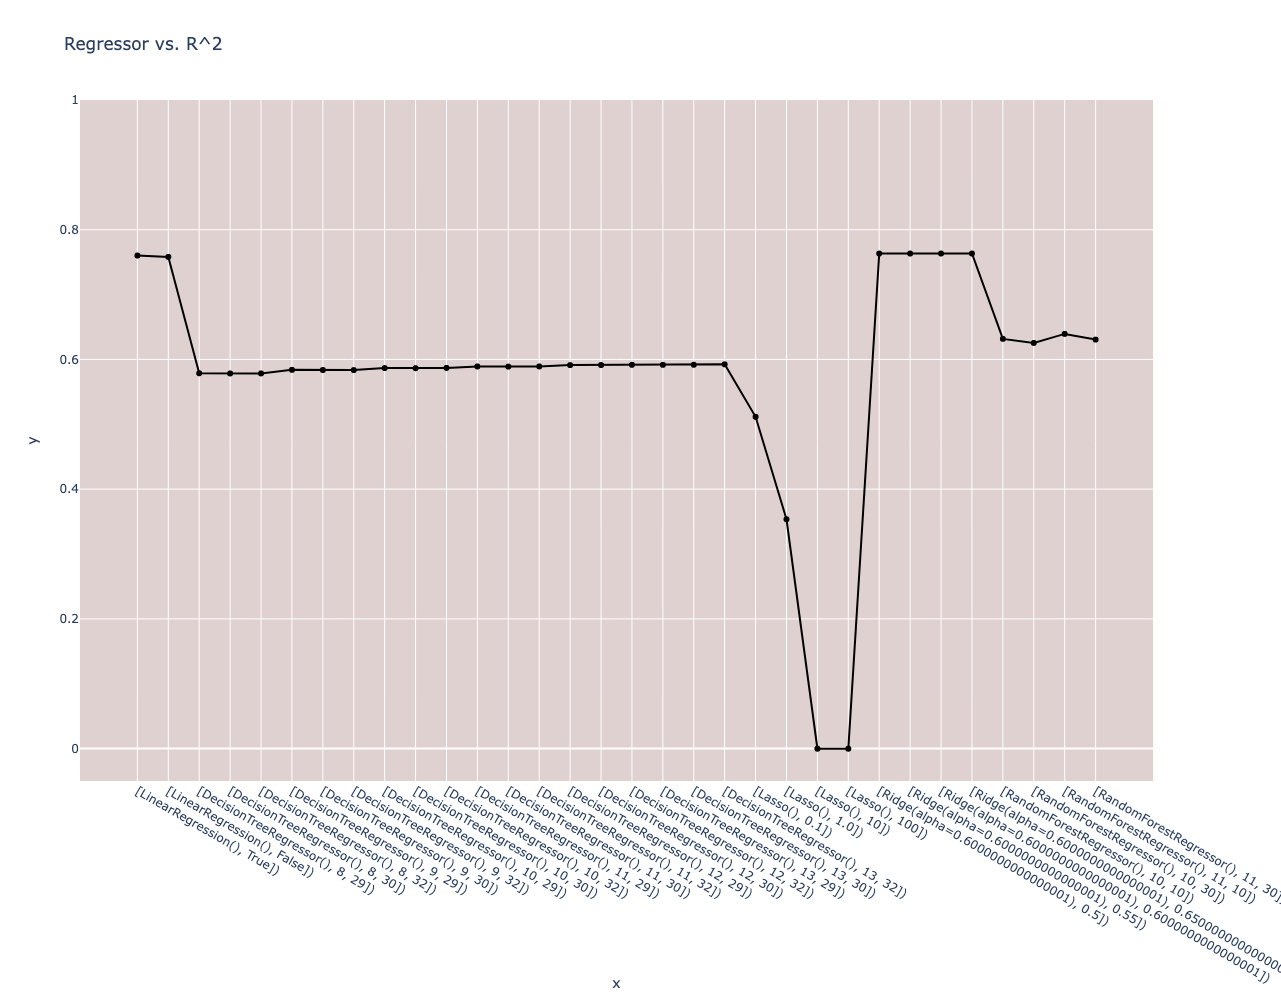

In [591]:
fig = px.line(x=regressors,y=r2s,range_y=(-0.05,1),width=1000,height=1000,labels=True,
              title='Regressor vs. R^2', markers=True,color_discrete_sequence=['black'],)
fig.update_layout({
'plot_bgcolor': 'rgba(0.4, 0.1, 0.1, 0.2)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})